#  Preliminary explorations of CSFLA parameter tuning

In [14]:
# Libraries and helper functions
import pickle
import json
import sys
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from toolz import get_config, get_all_config_results

def get_configurations(data, names):
    """
        Returns df on each test month with all configs of the names array
    """
    df = pd.concat(data.loc[data['config name'] == n] for n in names)
    return df.loc[df['data file'] == 'data/EUR_GBP/fx-spot_EUR_GBP_10min_201306.txt:fx-spot_EUR_GBP_10min_201306:02:20:21:28'][['config name', 'value']].set_index('config name'), df.loc[df['data file'] == 'data/EUR_GBP/fx-spot_EUR_GBP_10min_201307.txt:fx-spot_EUR_GBP_10min_201307:0:20:21:30'][['config name', 'value']].set_index('config name'), df.loc[df['data file'] == 'data/EUR_GBP/fx-spot_EUR_GBP_10min_201308.txt:fx-spot_EUR_GBP_10min_201308:0:20:21:29'][['config name', 'value']].set_index('config name')

def plot_train_months(june, july, august):
    plt.plot(june)
    plt.plot(july)
    plt.plot(august)
    plt.legend(['june', 'july', 'august'])
    plt.xticks(rotation=20)
    plt.xlabel('Configurations', size=14)
    plt.ylabel('Fitness value', size=14)


In [15]:
# Load data
cfg = get_config('../config/paramsexperiment1config.json')
all_configs = get_all_config_results(cfg, '../config/algos/csfla_param_exp_configs.json')

# Independent parameter testing 

First I want to test how params influence fitness in independence with each other. I thus create a set of configurations which have the same parameters as each other but with one parameter that differs to test that param's influence. 

## Total number of frogs 
The number of frogs is similar to the swarm size in the pso. 
I hypothesise that the higher the n_frogs, the more initial exploration is possible, so the better the results. However, it also increase computation as we increase the number of operations with it (fitness evaluations, frog comparisons, frog evolution).

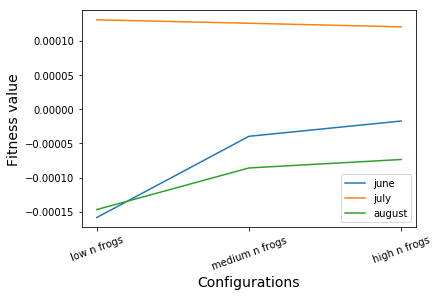

In [16]:
p_configs = ['low n frogs', 'reference', 'medium n frogs', 'high n frogs']
june, july, august = get_configurations(all_configs, p_configs)
plot_train_months(june, july, august)

## Number of memeplexes
It seems like fitness can increase with the number of memeplexes.
My interpretation would be: the more memeplexes we have, the more optimimums are explored. 

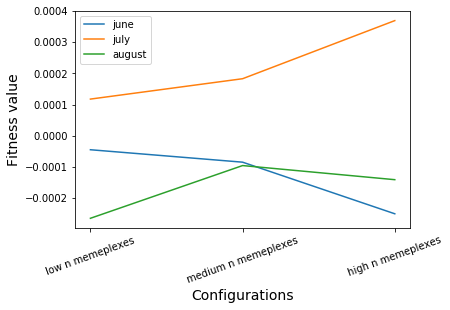

In [17]:
p_configs = ['low n memeplexes',  'medium n memeplexes', 'reference', 'high n memeplexes']
june, july, august = get_configurations(all_configs, p_configs)
plot_train_months(june, july, august)

## Number of frogs selected for sub-memeplex
The more frogs selected for a sub-memeplex, the lower the fitness of the lowest selected frog, and the higher the fitness of the best selected frog.

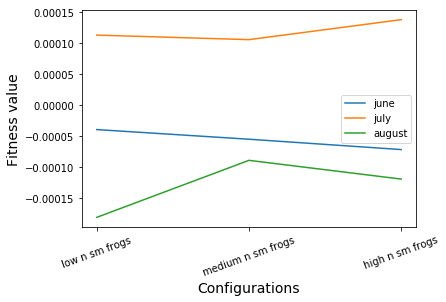

In [18]:
p_configs = ['low n sm frogs',  'medium n sm frogs', 'reference', 'high n sm frogs']
june, july, august = get_configurations(all_configs, p_configs)
plot_train_months(june, july, august)

## Number of generations
The higher the number of generations, the higher the global fitness, because we allow frogs to evolve over a higher number of iterations. 

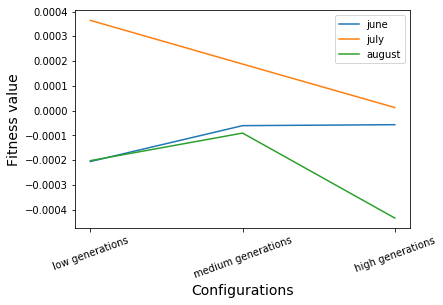

In [19]:
p_configs = ['low generations', 'medium generations', 'reference', 'high generations']
june, july, august = get_configurations(all_configs, p_configs)
plot_train_months(june, july, august)

## Number of sub-memeplex generations
The higher the number of s-m generations, the more niched the frogs become, the more we allow niches to be exploited.

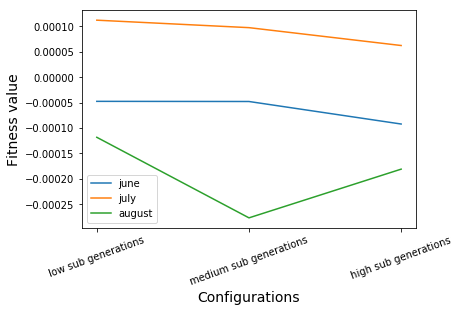

In [20]:
p_configs = ['low sub generations', 'medium sub generations', 'reference', 'high sub generations']
june, july, august = get_configurations(all_configs, p_configs)
plot_train_months(june, july, august)

## Conclusion of independent param examination

These results are similar to what was given with pso: generally speaking, parameters perform well when on extreme values, which is when they favor either exploration/generality or exploitation. 

I thus follow a similar strategy than with PSO and elaborate 5 strategies:


# Proposed combinatorial setups

I time each setup since we now take into account expensiveness of computation

## Reference
Arbitrarily 'medium' parameter set to serve as comparison

## Extreme Niching cheap
Niching params: high n memeplexes, high n frogs per sub-memeplexes, high n sub memeplex generations

Cost params: small n frogs, small n generations

## Extreme Niching expensive
Niching params: high n memeplexes, high n frogs per sub-memeplexes, high n sub memeplex generations

Cost params: high n frogs, high n generations


## Global cheap
Niching params: low n memeplexes, low n frogs per sub-memeplexes, low n sub memeplex generations

Cost params: small n frogs, small n generations



## Global expensive
Niching params: low n memeplexes, low n frogs per sub-memeplexes, low n sub memeplex generations

Cost params: high n frogs, high n generations


# RESULTS

In [22]:
# Load and group results
test_configs = get_all_config_results(cfg, '../config/algos/csfla_configs.json')
p_configs = ['reference', 'extreme niching cheap', 'extreme niching expensive', 'global cheap',  'global expensive']
june, july, august = get_configurations(test_configs, p_configs)
june['month'] = 'june'
july['month'] = 'july'
august['month'] = 'august'
fitnesses = june.append(july.append(august))
print(fitnesses)

                              value   month
config name                                
extreme niching expensive -0.000050    june
global cheap              -0.000038    june
global expensive          -0.000034    june
extreme niching expensive  0.000235    july
global cheap               0.000064    july
global expensive           0.000107    july
extreme niching expensive -0.000071  august
global cheap              -0.000107  august
global expensive          -0.000283  august


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

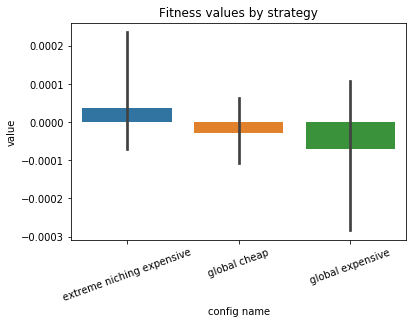

In [25]:
df = fitnesses.reset_index()

p = sns.barplot(x='config name', y='value', data=df).set_title('Fitness values by strategy')
plt.xticks(rotation=20)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

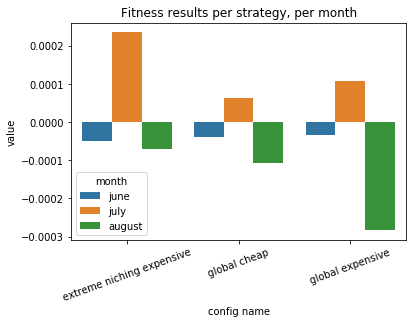

In [24]:
p = sns.barplot(x='config name', y='value', data=df, hue='month').set_title('Fitness results per strategy, per month')
plt.xticks(rotation=20)

## Interpretation
These first configurations seem to be much less promising than the PSO configurations.
